In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd

In [17]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [19]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [24]:
results = session.query(Measurement.date, Measurement.prcp)


In [25]:
print(results.all())

[('2010-01-01', 0.08), ('2010-01-02', 0.0), ('2010-01-03', 0.0), ('2010-01-04', 0.0), ('2010-01-06', None), ('2010-01-07', 0.06), ('2010-01-08', 0.0), ('2010-01-09', 0.0), ('2010-01-10', 0.0), ('2010-01-11', 0.01), ('2010-01-12', 0.0), ('2010-01-14', 0.0), ('2010-01-15', 0.0), ('2010-01-16', 0.0), ('2010-01-17', 0.0), ('2010-01-18', 0.0), ('2010-01-19', 0.0), ('2010-01-20', 0.0), ('2010-01-21', 0.0), ('2010-01-22', 0.0), ('2010-01-23', 0.0), ('2010-01-24', 0.01), ('2010-01-25', 0.0), ('2010-01-26', 0.04), ('2010-01-27', 0.12), ('2010-01-28', 0.0), ('2010-01-30', None), ('2010-01-31', 0.03), ('2010-02-01', 0.01), ('2010-02-03', None), ('2010-02-04', 0.01), ('2010-02-05', 0.0), ('2010-02-06', 0.0), ('2010-02-07', 0.0), ('2010-02-08', 0.0), ('2010-02-09', 0.0), ('2010-02-11', 0.0), ('2010-02-12', 0.02), ('2010-02-13', 0.01), ('2010-02-14', 0.0), ('2010-02-15', 0.0), ('2010-02-16', 0.0), ('2010-02-17', 0.0), ('2010-02-19', None), ('2010-02-20', 0.03), ('2010-02-21', 0.0), ('2010-02-22', 0.

# Exploratory Climate Analysis

In [26]:
#Starting from the last data point in the database. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

In [27]:
# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [28]:
# Design a Query to Retrieve the Last 12 Months of Precipitation Data Selecting Only the `date` and `prcp` Values
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [29]:
# Perform a query to retrieve the data and precipitation scores
all_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()

In [30]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [31]:
# Sort the dataframe by date

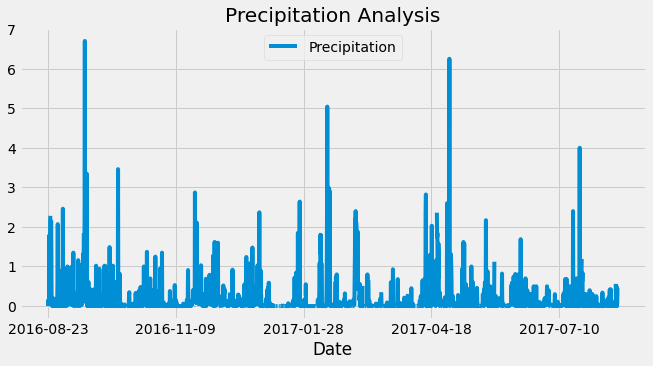

In [32]:
# Use Pandas Plotting with Matplotlib to `plot` the Data
prcp_df.plot(title="Precipitation Analysis", figsize=(10,5))
plt.legend(loc='upper center')
plt.savefig("Images precipitation.png")
plt.show()

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [34]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9,)]

In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), 
              func.max(Measurement.tobs), 
              func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

min_max_avg_temp = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
min_max_avg_temp

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# What are the most active stations?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

In [12]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [35]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Create a query to select the column. 
session.query(Measurement.tobs)

In [53]:
# Filter the stations.
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281')

In [55]:
# Convert the results to a DataFrame.
df = pd.DataFrame(results, columns=['tobs'])

<AxesSubplot:ylabel='Frequency'>

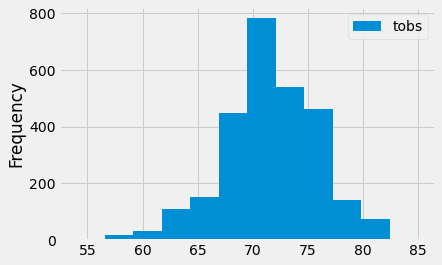

In [50]:
# Plot highest number of Observation
df.plot.hist(bins=12)

In [51]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Challenge